### Time Series - Analyzing Air Passengers Trend

In [24]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import seaborn as sns
sns.set_style('darkgrid')

In [25]:
# Inspect the data directory
!ls

AirPassengers.csv
Timeseries Analysis - Python.ipynb


In [26]:
# Data Loading
airpass_df = pd.read_csv('AirPassengers.csv')
airpass_df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [27]:
airpass_df.dtypes

Month          object
#Passengers     int64
dtype: object

The data contains a particular month and number of passengers travelling in that month. But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [28]:
parse_dates = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
airpass_df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=parse_dates)
airpass_df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [29]:
# Convert the column to a series object
ts = airpass_df["#Passengers"]
ts[:5]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [30]:
ts['1949-02-01']

118

In [31]:
from datetime import datetime
ts[datetime(1949, 2, 1)]

118

In [32]:
ts[:'1949-10-1']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [33]:
# Selecting a particular year
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

### Checking the Stationarity of a Time Series

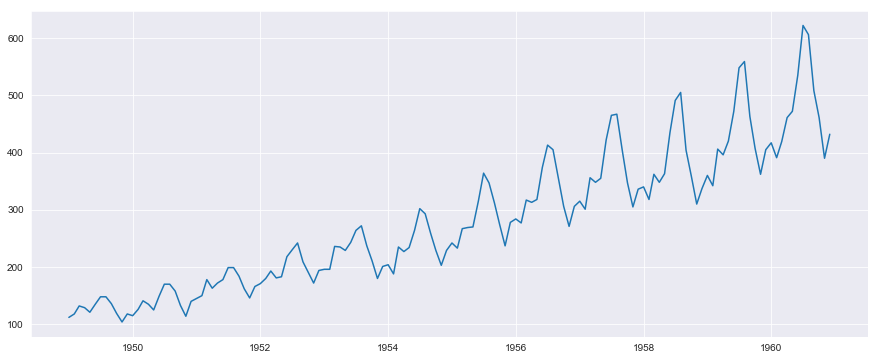

In [34]:
plt.plot(ts)

For a **Time Series** to be termed as **Stationery** it should posses the following:
   - A constant mean
   - A constant variance
   - An autocovariance that doesn't depend on time

Apart from plotting the time series we can formally confirm Stationarity through the following:
  - **Plotting Rolling Statistics i.e also a visual approach**
  - **Performing a Dickey-Fuller Test**

### Plotting Rolling Statistics

We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

### Dickey Fuller's Test

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [40]:
## Import Dickey Fuller for StatsModel
from statsmodels.tsa.stattools import adfuller


# Function to Test Stationarity
def test_stationarity(timeseries):
    
    """ The function takes the timeseries as input and outputs a graph of Rolling Statistics
        and Results of a Dickey-Fuller Test on the Time Series """
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Rolling Statistics Plot
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller's Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

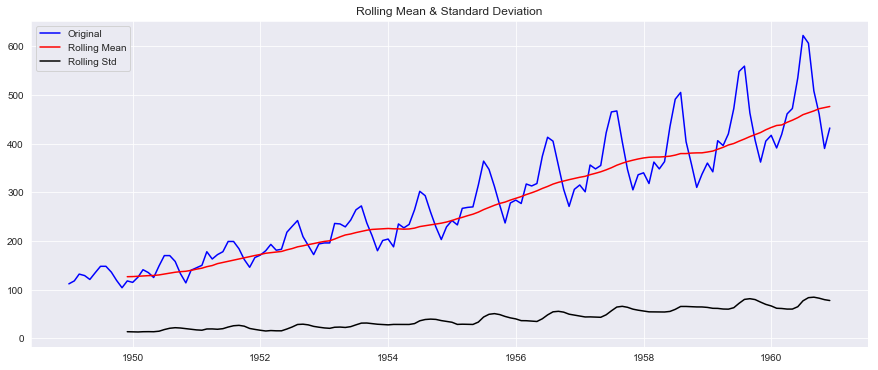

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [42]:
test_stationarity(ts)

#### Comments:

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

### How to make a Time Series Stationery

Reasons behind non-stationarity of a Time Series is:

 - **Trend - varing mean e.g. number of passengers growing overtime**
 - **Seasonality - variations as timeframe due to seasonal events**

The main principle for a time series is modeling/estimating the seasonality/trend then remove it from the series to get a **stationary series**. After forecasting techniques are applied on the series the final step is to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

### Eliminating Trend in a Time Series

The first trick to reduce trend is through tranformation this is where you do a log, cube or square root of the values to penalize the larger values in the series.

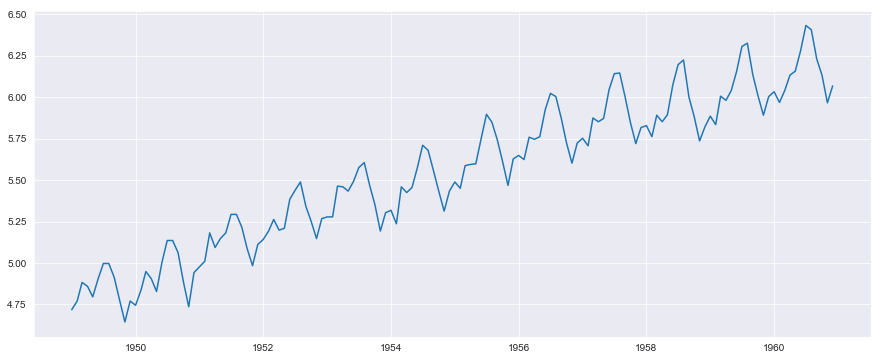

In [44]:
ts_logged = np.log(ts)
plt.plot(ts_logged)

In [52]:
type(ts_logged)

pandas.core.series.Series

## Smoothing

### Moving Average

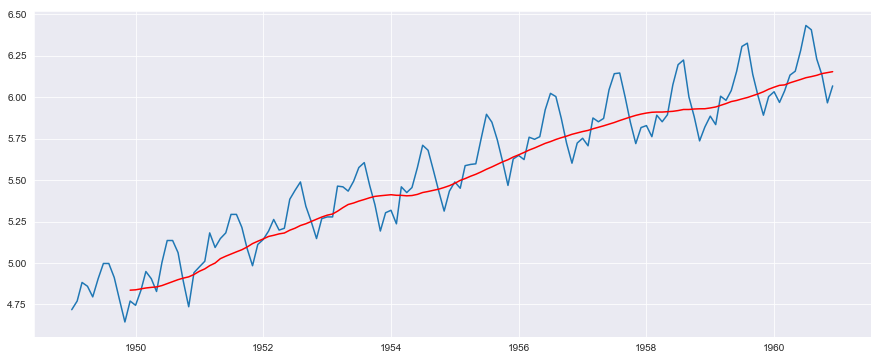

In [46]:
moving_avg = ts_logged.rolling(12).mean()
plt.plot(ts_logged)
plt.plot(moving_avg, color='red')

Remove (Substract) moving average from the ts_logged: **timeseries - moving_average**

In [47]:
ts_log_minus_mov_avg = ts_logged - moving_avg
ts_log_minus_mov_avg.head()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #Passengers, dtype: float64

In [48]:
ts_log_minus_mov_avg.dropna(inplace=True)
ts_log_minus_mov_avg.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

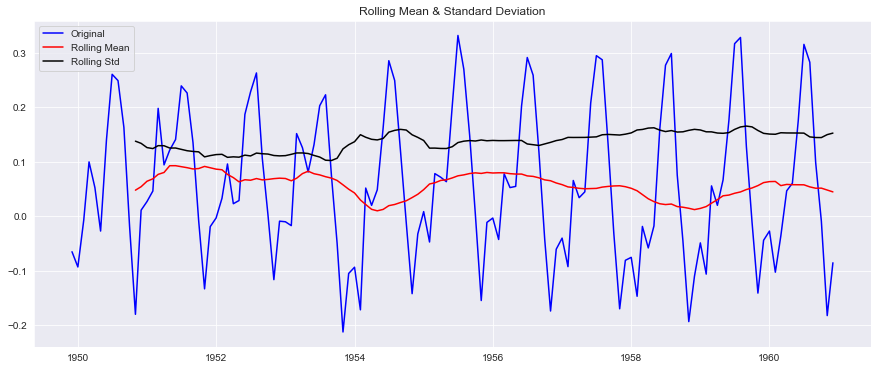

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [49]:
test_stationarity(ts_log_minus_mov_avg)

### Explonentially Weighted Moving Average

In [55]:
# exp_weighted_mov_avg = pd.ewma(ts_logged, halflife=12)
# exp_weighted_mov_avg = ts.ewma(halflife=12)
# plt.plot(ts_logged)
# plt.plot(exp_weighted_mov_avg, color='red')

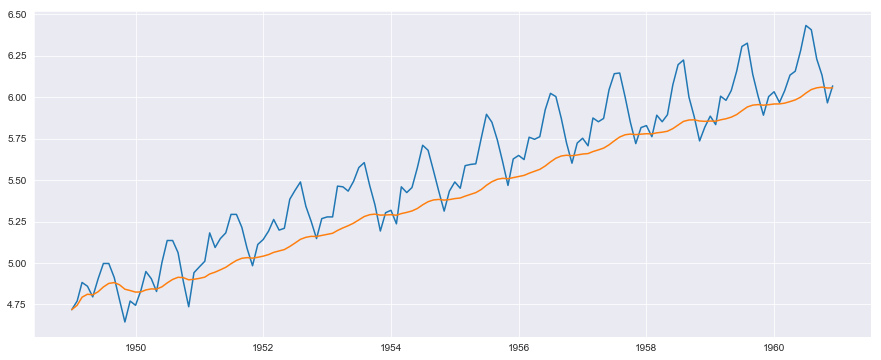

In [64]:
# airpass_df['#Passengers'] = airpass_df['#Passengers'].apply(lambda x: np.log(x))
exp_weighted_mov_avg = airpass_df.ewm(halflife=12).mean()
plt.plot(ts_logged)
plt.plot(exp_weighted_mov_avg)

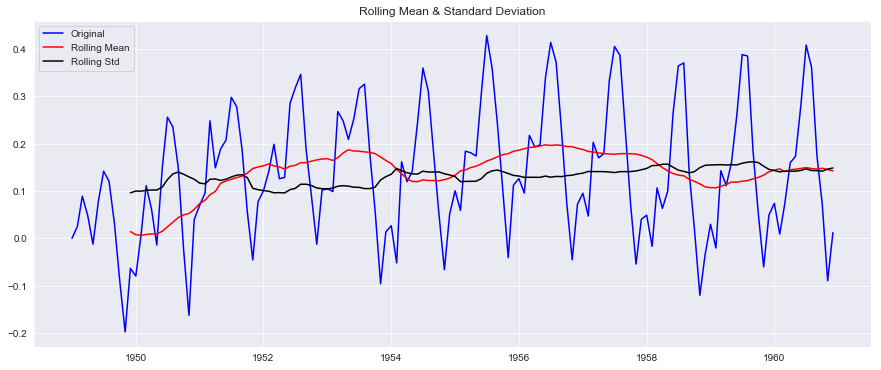

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [68]:
ts_logged_minus_ewma = ts_logged - exp_weighted_mov_avg['#Passengers']
test_stationarity(ts_logged_minus_ewma)

## Eliminating Trend and Seasonality 

### Differencing

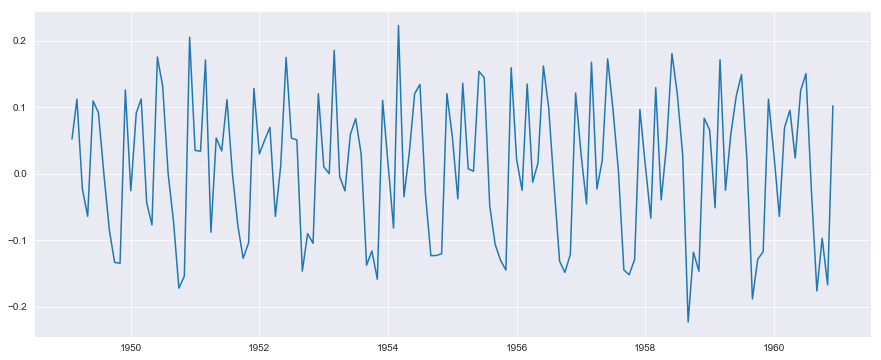

In [72]:
## The first Difference
ts_log_differenced = ts_logged - ts_logged.shift()
plt.plot(ts_log_differenced)

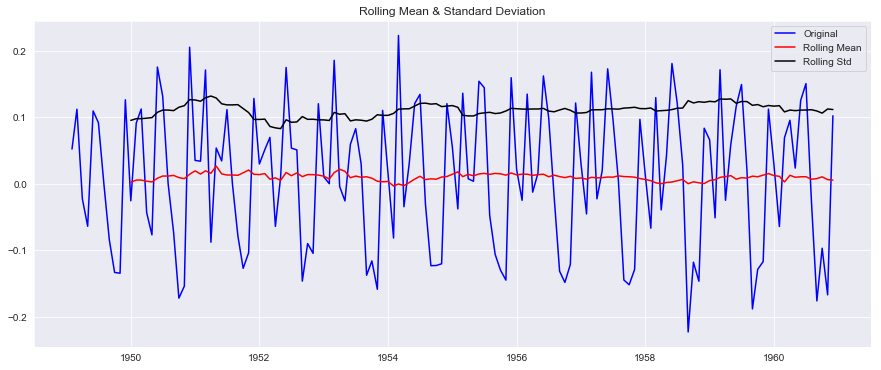

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [73]:
ts_log_differenced.dropna(inplace=True)
test_stationarity(ts_log_differenced)

### Decomposing

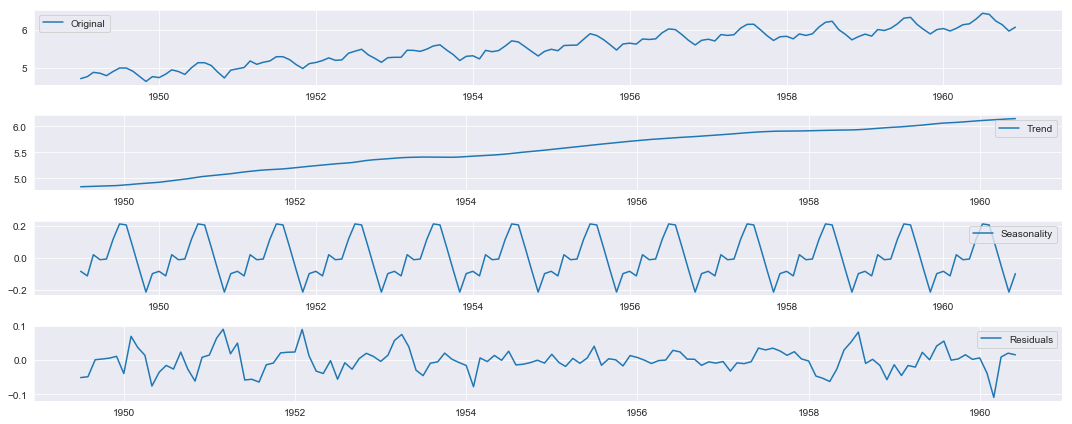

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_logged)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_logged, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

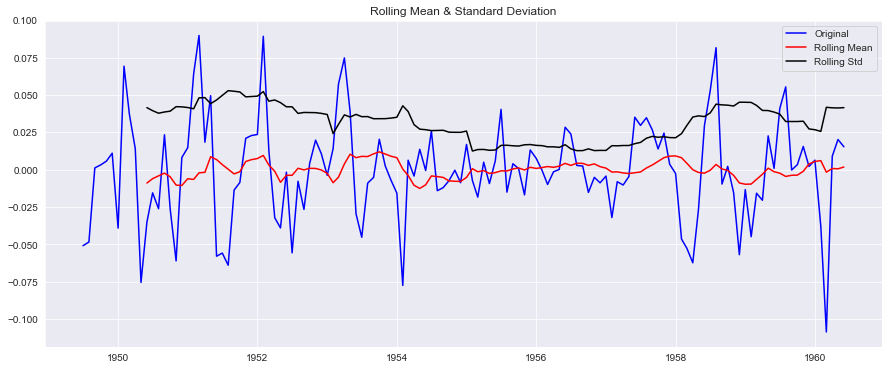

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [77]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

## Time Series Forecasting

In [78]:
from statsmodels.tsa.arima_model import ARIMA

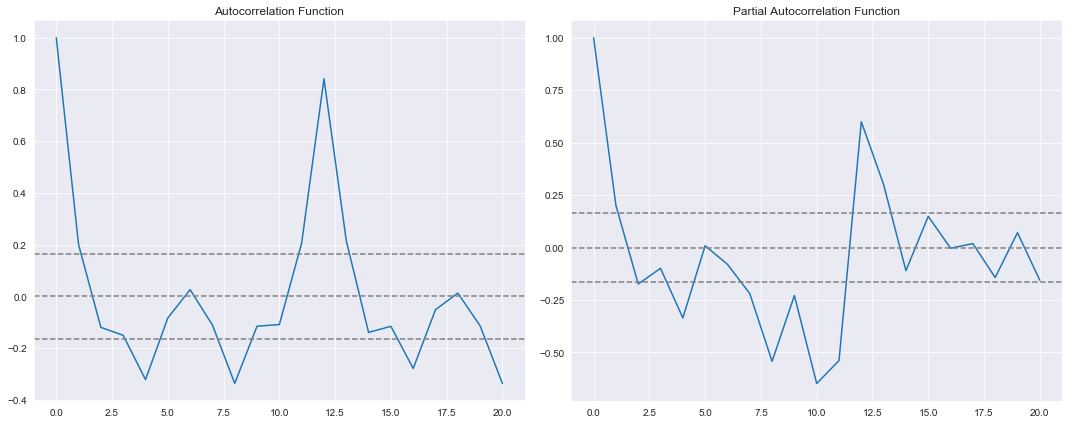

In [80]:
# Auto Correlated Function and Partial Auto Correlated Function plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_differenced, nlags=20)
lag_pacf = pacf(ts_log_differenced, nlags=20, method='ols')

# Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_differenced)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_differenced)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_differenced)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_differenced)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Auto Regressive Model

c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

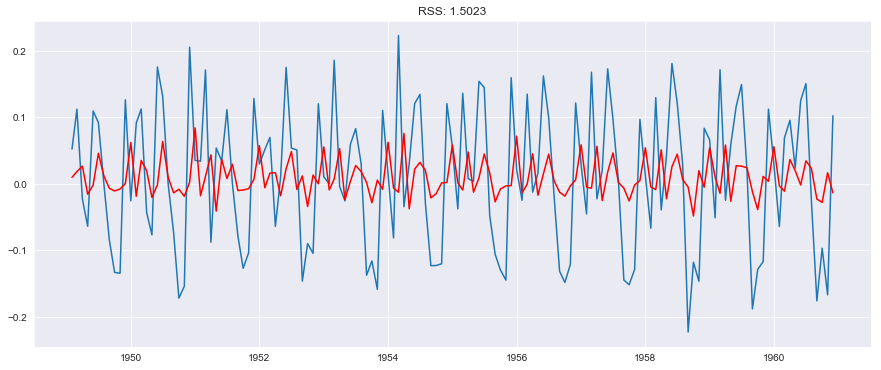

In [83]:
model = ARIMA(ts_logged, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_differenced)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_differenced)**2))

### Moving Average Model

c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

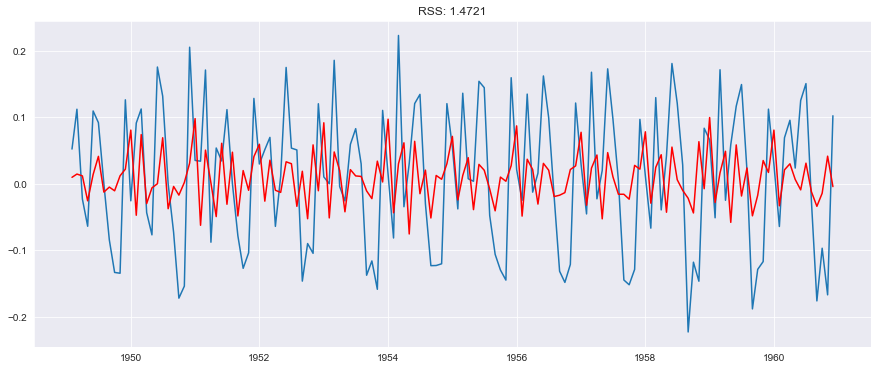

In [84]:
model = ARIMA(ts_logged, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_differenced)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_differenced)**2))

### ARIMA Model

c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\botieno\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

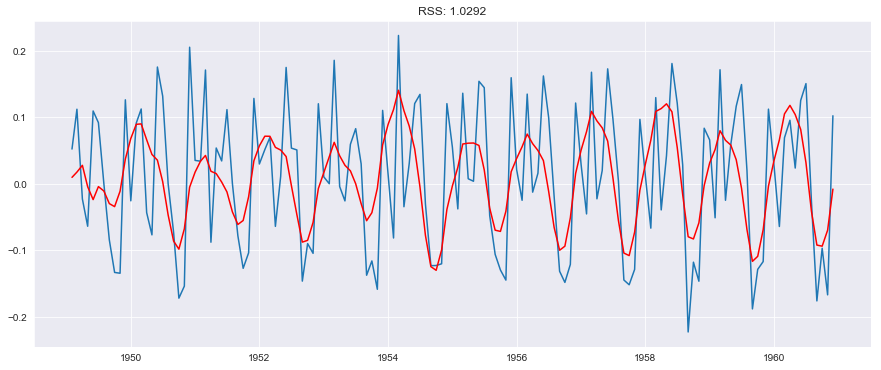

In [86]:
model = ARIMA(ts_logged, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_differenced)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_differenced)**2))

### Convert the fitted values to Original Scale

In [88]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [90]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [95]:
predictions_ARIMA_log = pd.Series(ts_logged.iloc[0], index=ts_logged.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

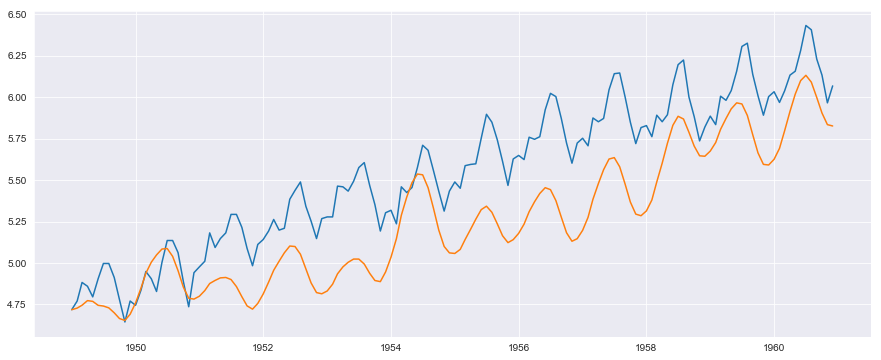

In [96]:
plt.plot(ts_logged)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 90.1046')

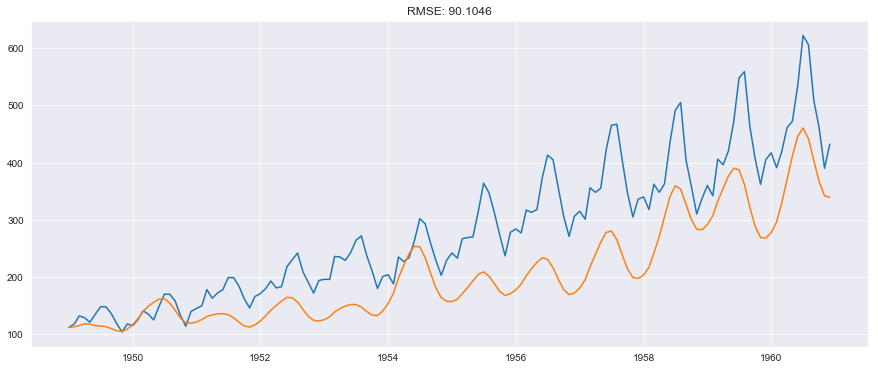

In [97]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))